### actual prediction sequence

In [ ]:
import numpy as np
start_time ="05-04-17-00-11-12" #"05-03-17-19-06-14"#"05-02-17-13-55-40"
exps=["logistic"]
#exps=["logistic","traffic","climate"]
#models = ["basic_rnn", "basic_lstm", "matrix_rnn", "tensor_rnn", "tensor_rnn_einsum"]
models=["basic_lstm","tensor_rnn_einsum"]

preds = []
for exp in exps:
    for model in models:
        data_path = "/tmp/tensorRNN/log/"+exp+"/"+start_time+"/"+model
        file_name = "predict.npy"
        print(data_path+"/"+file_name)
        try:
            pred = np.load(data_path+"/"+file_name) 
            preds.append(np.asarray(pred))
        except IOError:
            'no file'    
print(np.shape(pred))


In [ ]:
pred_lstm = preds[0]
pred_trnn = preds[1]
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 2)) #(9*16, width=3.5)

y_true, y_pred = pred_lstm
y_true = y_true[:100]
y_pred = y_pred[:100]
t = np.arange(0,len(y_true))
#plt.plot(t,y_pred,'r')

plt.subplot(1,4,1)
plt.plot(t,y_true,'b')


plt.subplot(1,4,2)
plt.plot(t,y_true,'r')


y_true, y_pred = pred_trnn
y_true = y_true[:100]
y_pred = y_pred[:100]
plt.subplot(1,4,3)
plt.plot(t,y_true,'b')

plt.subplot(1,4,4)
plt.plot(t,y_true,'r')

### version 2 lorenz visualization

In [129]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

def gen_lorenz_series(x0, y0, z0, num_steps, num_freq):
    dt = 0.01
    stepCnt = num_steps

    # Need one more for the initial values
    xs = np.empty((stepCnt,))
    ys = np.empty((stepCnt,))
    zs = np.empty((stepCnt,))

    # Setting initial values
    #xs[0], ys[0], zs[0] = (0., 1., 1.05)
    xs[0] = x0
    ys[0] = y0
    zs[0] = z0

    xss = np.empty((stepCnt//num_freq,))
    yss = np.empty((stepCnt//num_freq,))
    zss = np.empty((stepCnt//num_freq,))
    # Stepping through "time".
    j = 0
    for i in range(stepCnt-1):
        # Derivatives of the X, Y, Z state
        if i%num_freq ==0:
            xss[j] = xs[i]
            yss[j] = ys[i]
            zss[j] = zs[i]
            j += 1
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)

    #save the sequence for training
    lorenz_series = np.transpose(np.vstack((xss,yss,zss)))
    return lorenz_series

def gen_lorenz_dataset(file_name="lorenz.pkl"):
    #define initial range
    num_samples = int(1e4)
    num_freq = int(5)
    num_steps = int(1e2)*num_freq
    
    init_range = np.random.uniform(-20,20,(num_samples,3))
   
    lorenz_series_mat = np.ndarray((num_samples, num_steps//num_freq, 3))

    for i in range(num_samples):
        x0,y0,z0 = init_range[i,:]
        series = gen_lorenz_series(x0,y0,z0, num_steps, num_freq )
        lorenz_series_mat[i,:,:] = series
    return lorenz_series_mat

data_mat = gen_lorenz_dataset()


    #pickle.dump(lorenz_series_mat, open(file_name,"wb")) 

In [131]:
import seaborn as sns
import cPickle as pickle
data_path = "/home/roseyu/data/tensorRNN/"
file_name = "lorenz.pkl"

print(np.shape(data_mat))
with open(data_path+file_name,'wb') as f:
    pickle.dump(data_mat, f)
    
# with open(data_path+file_name, 'rb') as f:
#     data_mat = pickle.load(f)

(10000, 100, 3)


data_shape: (10000, 100, 3)
[8984 4279 5313 9705 7487 6107  725 5729 1771 4098]
('xyz0:', array([-14.63890302,   3.28820811,   1.461579  ]))
('xyz0:', array([ 18.19190497,   3.22561288,  -2.9706709 ]))
('xyz0:', array([ -3.13214305, -17.40520357, -16.3503449 ]))
('xyz0:', array([ 12.19565758,  -7.81437735,  -2.83289536]))
('xyz0:', array([-10.05496177,  -7.43635444,   6.12666244]))
('xyz0:', array([-3.87105605, -1.64596929, -9.27727241]))
('xyz0:', array([  2.68439669,   7.43087525,  19.7511142 ]))
('xyz0:', array([ -2.20021678,   0.7122365 ,  14.60104731]))
('xyz0:', array([-17.58429638,  15.43533405,  -6.66751016]))
('xyz0:', array([ 14.75542101,   7.09259413,  12.51337572]))


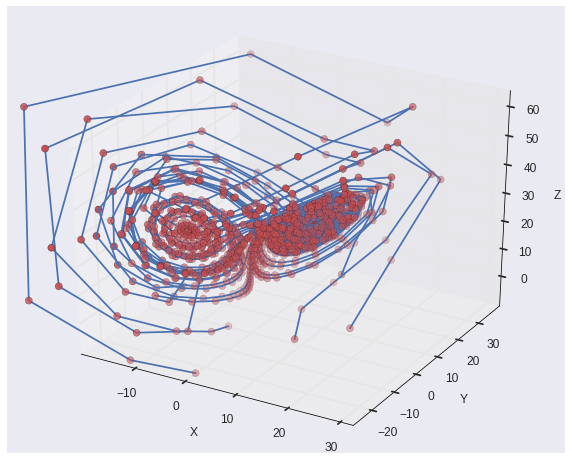

In [142]:
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

params = {
   'axes.labelsize': 12,
   'text.fontsize': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
mpl.rcParams.update(params)

print("data_shape:"), np.shape(data_mat)
N = 10
# xs = data_mat[0:N,:,0]
# ys = data_mat[0:N,:,1]
# zs = data_mat[0:N,:,2]
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

def mm(x):
    return np.min(x)-10, np.max(x)+10

idxs = np.random.choice(range(data_mat.shape[0]), N)
print(idxs)
for i in idxs:
    print("xyz0:",data_mat[i,0])
    ax.plot(data_mat[i,:,0], data_mat[i,:,1], data_mat[i,:,2], 'b')
    ax.scatter(data_mat[i,:,0], data_mat[i,:,1], data_mat[i,:,2], c='r', s=50)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(*mm(xs))
ax.set_ylim(*mm(ys))
ax.set_zlim(*mm(zs))
fig.savefig('/home/roseyu/lorenz.pdf', transparent=True)

### projection of the weight vector

In [154]:
from tensorflow.python.ops import variable_scope as vs


rank_vals = [1]
num_orders = len(rank_vals)+1#alpha_1 to alpha_{K-1}
num_lags = 3
num_orders = 2
batch_size = 5
state_size = 128 #hidden layer size
input_size= 3 #data dimension

# with vs.variable_scope("tensor_network_tt") as scope:
total_state_size = (state_size * num_lags + 1 )
mat_dims = np.ones((num_orders,)) * total_state_size
mat_ranks = np.concatenate(([1], rank_vals, [output_size]))
mat_ps = np.cumsum(np.concatenate(([0], mat_ranks[:-1] * mat_dims * mat_ranks[1:])),dtype=np.int32)
mat_size = mat_ps[-1]

weights_x = vs.get_variable("weights_x", [input_size, output_size] )

mat = vs.get_variable("weights_h", mat_size) # h_z x h_z... x output_size
# Add ops to saev† and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
model_file = "/tmp/tensorRNN/log/climate/05-02-17-13-55-40/tensor_rnn_einsum/checkpoint"

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, model_file)
    print("Model restored.")
    # Do some work with the model
 

ValueError: Variable weights_x already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-153-148057565b53>", line 19, in <module>
    weights_x = vs.get_variable("weights_x", [input_size, output_size] )
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):


In [10]:
import tensorflow as tf
from tensorflow.python.framework import ops
sess = tf.Session()
file_path = "/tmp/tensorRNN/log/climate/05-02-17-13-55-40/tensor_rnn_einsum/"

meta_file = "model.ckpt-0.meta"
model_file = "model.ckpt-0"
new_saver = tf.train.import_meta_graph(file_path+meta_file)
#print( tf.train.latest_checkpoint('./'))
what=new_saver.restore(sess, file_path+model_file)
#print(what)
all_vars = tf.get_collection(ops.GraphKeys.GLOBAL_VARIABLES)
print(all_vars)
for v in all_vars:
    v_ = sess.run(v)
    print(v_)

ImportError: No module named ops